In [151]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import imageio
import pathlib

In [122]:
incident = pd.read_stata('data/ESOC-I_Replication_V3/stata/incident/esoc-iraq-v3_sigact_district-month.dta')
shape = gpd.read_file('data/ESOC-I_Replication_V3/gis/Iraq_district_boundaries_UTM.shp')

In [19]:
sorted(incident.columns)

['SIGACT',
 'SIG_1',
 'df',
 'district',
 'district_1',
 'district_2',
 'idf',
 'ied_attack',
 'ied_clear',
 'ied_total',
 'month',
 'suicide']

In [155]:
incident.describe()

,month,SIGACT,SIG_1,df,idf,suicide,ied_attack,ied_clear,ied_total
count,6344.000000,6344.000000,6344.000000,6344.000000,6344.000000,6344.000000,6344.000000,6344.000000,6344.000000
mean,559.000000,30.734237,26.849779,8.810687,1.005202,0.118695,11.566362,3.662043,15.228405
std,17.608205,87.531057,71.636469,29.397689,4.793297,0.585928,29.227098,13.848676,38.228468
min,529.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,544.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,559.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,574.000000,20.000000,18.000000,4.000000,0.000000,0.000000,8.000000,0.000000,11.000000
max,589.000000,1404.000000,954.000000,481.000000,139.000000,10.000000,398.000000,221.000000,408.000000


In [20]:
shape.head()

,OBJECTID,ADM3NAME,ADM3CODE,ADM2NAME,ADM2CODE,AREA_KM2,PERIM_KM,geometry
0,1,Al-Shikhan,iq15053,Ninewa,iq15,1304.477640,185.494463,"POLYGON ((350251.1781525754 4088587.202536595,..."
1,2,Tilkaif,iq15100,Ninewa,iq15,1247.191304,168.651504,"POLYGON ((336407.3752001523 4072765.905629623,..."
2,3,Al-Hamdaniya,iq15017,Ninewa,iq15,1785.729624,220.723098,"POLYGON ((355051.4594224204 4045638.872971167,..."
3,4,Mosul,iq15038,Ninewa,iq15,4335.375726,420.809044,"POLYGON ((298474.1498184187 4045966.474228984,..."
4,5,Telafar,iq15098,Ninewa,iq15,4460.156834,424.953377,"POLYGON ((310019.2649601049 4065053.948503999,..."


In [93]:
summed = incident.groupby(["district"]).sum().reset_index()
merged = shape.set_index('ADM3NAME').join(summed.set_index('district'))

In [39]:
def renderPlot(df,variable,title):
  vmin, vmax = 0, df[variable].max()
  
  fig, ax = plt.subplots(1, figsize=(10, 6))

  # create map
  df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

  # Now we can customise and add annotations

  # remove the axis
  ax.axis('off')

  # add a title
  ax.set_title(title, \
                fontdict={'fontsize': '25',
                          'fontweight' : '3'})

  # create an annotation for the  data source
  ax.annotate('Source: Multi-National Forces Iraq (MNF-I) SIGACT III database',
             xy=(0.1, .08), xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='top',
             fontsize=10, color='#555555')

  # Create colorbar as a legend
  sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm._A = []
  cbar = fig.colorbar(sm)

  # this will save the figure as a high-res png. you can also save as svg
  fig.savefig('render/01_'+variable+'.png', dpi=300)

## Working on an Animated version

In [83]:
incident_yr = pd.read_stata('data/ESOC-I_Replication_V3/stata/incident/esoc-iraq-v3_sigact_district-year.dta')

In [110]:
summed_year = incident_yr.groupby(["district"])
merged_anim = shape.set_index('ADM3NAME').join(incident_yr.set_index('district'))

In [142]:
merged_anim["year"].unique()

array([2004, 2005, 2006, 2007, 2008, 2009])

In [153]:
def renderAnimatedPlot(df,variable,iterator,title):
  output_path = 'render/animate'

  i = 0
  list_of_years = sorted(df[iterator].unique())

  # set the min and max range for the choropleth map
  vmin, vmax = df[variable].min(), df[variable].max()
  
  kargs = { 'duration': 1 }
  images = []

  # start the for loop to create one map per year
  for year in list_of_years:
    # create map
    fig = df[df.year == year].plot(column=variable, cmap='Purples', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # remove axis of chart
    fig.axis('off')

    # add a title
    fig.set_title(title, \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})

    # create an annotation for the year
    only_year = year

    # position the annotation to the bottom left
    fig.annotate(only_year,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)

    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, '01_'+str(only_year)+'_'+variable+'.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)
    images.append(imageio.imread(filepath))
    os.remove(filepath)
  imageio.mimsave('render/01_'+variable+'_animated.gif', images, **kargs)

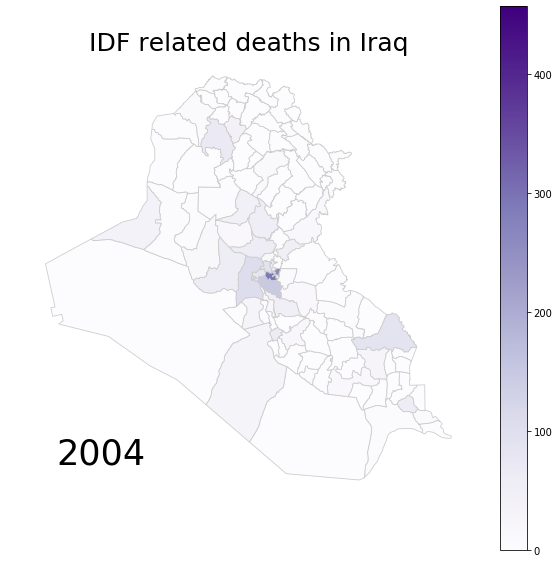

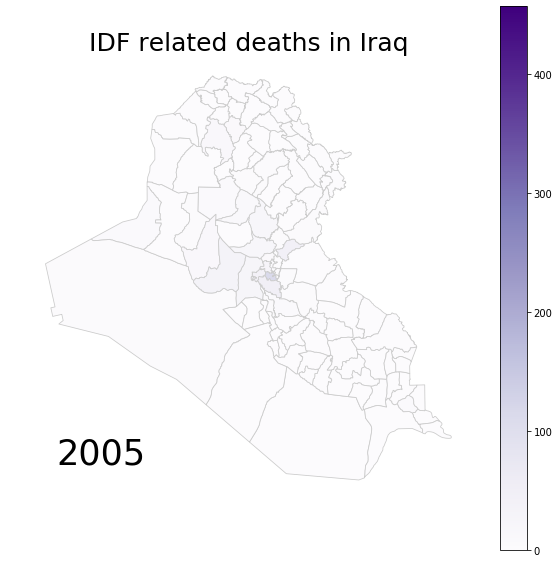

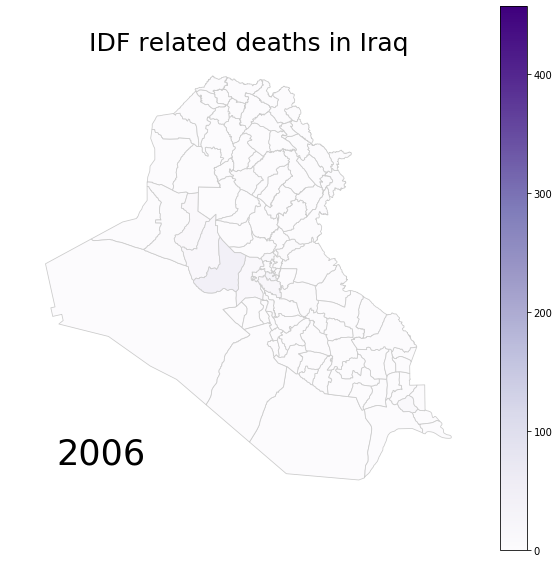

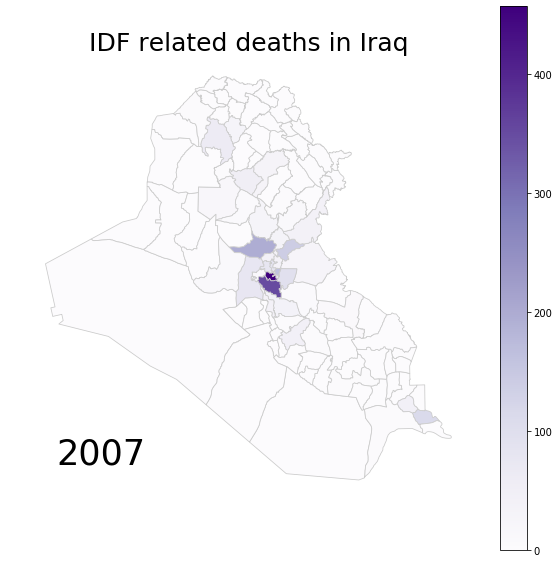

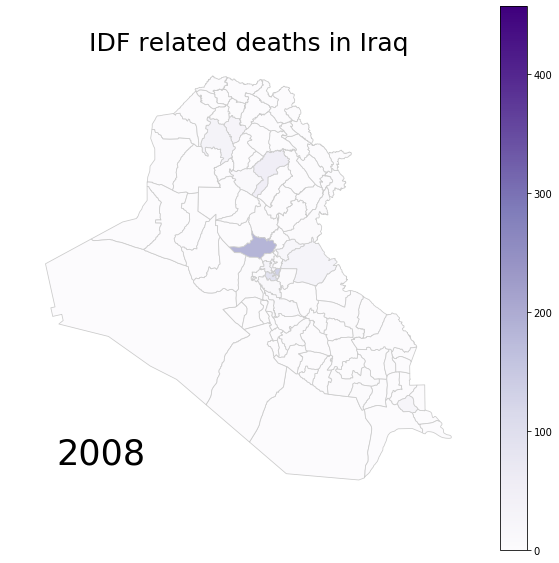

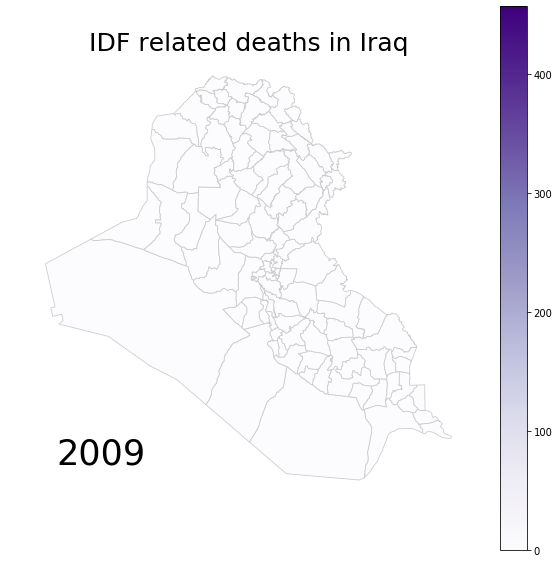

In [154]:
renderAnimatedPlot(df=merged_anim, variable="idf", iterator="year" ,title="IDF related deaths in Iraq")

In [135]:
3

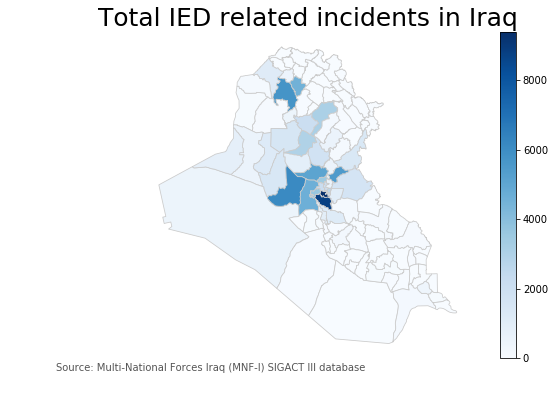

In [41]:
renderPlot(merged, "ied_total", "Total IED related incidents in Iraq")